# Chapter 2. Introduction to NLP: NL and distribution of words

In [1]:
# text corpus
text = 'You say goodbye and I say hello.'

In [2]:
# 소문자화 lower(), 문자열 대체 replace(target_str, change_to_this)
text = text.lower()
text = text.replace('.', ' .')
print(text)
# 대문자화 upper()
print(text.upper())

you say goodbye and i say hello .
YOU SAY GOODBYE AND I SAY HELLO .


In [3]:
# 공백 (띄어쓰기)에 따른 단어 분리 method split(' ')
# Default : ' ', 공백에 따른 분리
# strs.split(sep=' ')
words = text.split(' ')
words

# regular expression도 사용 가능.

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [4]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

In [5]:
word_to_id

{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}

In [6]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [7]:
# Word ID list
import numpy as np

corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [8]:
# Words preprocessing function
import sys
sys.path.append('..')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

# 단어의 분산 표현 (distributional representation of words)

단어를 어떻게 벡터화할 것인가? = 머신러닝에 사용하기 위해 단어를 벡터로 표현하는 방법

## 통계 기반 기법 (Statistical-based)

- 분포 가설 (distributional hypothesis)
    - '단어의 의미는 주변 단어에 의해 형성된다.' <br>
    - "문맥, 맥락 (Context)"이 단어의 의미를 형성한다.
        - Example : "drink" 다음에는 마실 수 있는 대상이 나올 것. (I drink beer)
        
    - 타겟 단어와 가장 가까이 있는 단어들로 맥락을 형성한다고 가정.
    - window size : 어느정도 가까이 있는 단어까지 볼 것이냐? 
        - Example : you say goodbye and i say hello. 에서, <br>
        goodbye가 타겟일 경우, window_size = 2일시, 'you', 'say', 'and' 'i' 까지의 단어로 맥락을 유추. (좌우 2단어가 맥락에 포함)
        
               
- 타겟 단어의 주변에 어떤 단어가 몇 번이나 등장하는지를 세어보는 게 가장 직관적인 방법.

In [9]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, most_similar

In [10]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

# Corpus : 말뭉치, 원문 텍스트의 단어들의 id 목록으로 변환함.
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [11]:
# Co-occurence matrix (동시발생 행렬)
# 주어진 단어에 대해 인접한 단어를 세어 행렬로 표현.

C = create_co_matrix(corpus, len(corpus), 1)

In [12]:
# Vector similarity, cosine similarity.

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0,c1))

0.7071067758832467


In [13]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus,vocab_size)

In [14]:
most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
goodbye: 0.7071067758832467
i: 0.7071067758832467
hello: 0.7071067758832467
say: 0.0
and: 0.0


NOTE : 위의 결과에서 goodbye와 you의 유사도가 높게 측정되었는데, <br> 
말뭉치의 크기가 작은 것이 원인 중 하나이다.

### Pointwise Mutual Information (PMI), 상호정보량

$ \text{PMI}(x,y) = \log_{2}{\frac{P(x,y)}{P(x)P(y)}} . $ <br>
- $P(x)$ = probability that event $x$ occurs.
- $P(x, y)$ : Joint probability. (cf: Conditional probability, 조건부 확률)

Example : $P(\text{'you'}) = 1/7$ (in the text 'You say goodbye and I say hello.')

**동시발생 행렬 $C$를 사용하여 $P(x,y)$를 적을 수 있음.**

$ \text{PMI}(x,y) = \log_{2}{\frac{P(x,y)}{P(x)P(y)}} = \log_{2}{\frac{C(x,y)/N}{C(x)C(y)/N^2}} = 
\log_{2}{\frac{C(x,y)\cdot N}{C(x)C(y)}} .$ <br>
- $C(x)$ : frequency of x
- $C(x,y)$ : x와 y가 동시발생하는 횟수 (행렬 $C$에서!)
- $N$ : 말뭉치에서 단어의 개수.

PMI는 음수가 나올 수도 있는데, 음수는 0으로 처리한다. (**Positive PMI, PPMI**)

$ \text{PPMI}(x,y) = \text{max}(0,PMI(x,y)) . $

In [15]:
# PPMI test
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus,vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)
print("Co-martix")
print(C)
print('-'*50)
print('PPMI')
print(W)

Co-martix
[[0 1 0 0 0 0 0 0]
 [1 0 1 0 1 1 0 0]
 [0 1 0 1 0 0 0 0]
 [0 0 1 0 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807 0.   ]
 [0.    0.    0.    0.    0.    2.807 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.   ]]


/Users/shong/project/DL_from_scratch02_note/ch02_intro_NLP/../common/util.py:80: RuntimeWarning: invalid value encountered in long_scalars
  pmi = np.log2(C[i,j] * N / (S[j]*S[i]) +eps)


PPMI의 문제점 
1. 말뭉치 개수가 많아지면 사이즈가 너무 커짐.
2. Sparse matrix의 형태를 띔.

### Dimensionality reduction, 차원 감소

Example : 2차원에서 1차원 경향성 (직선)을 띄는 데이터를 가지고 축 $y=ax + b$을 찾음. <br>
여기서는 SVD를 사용해서 차원 축소를 해본다!

In [16]:
# PPMI + SVD test
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus,vocab_size)
W = ppmi(C)

U, S, V = np.linalg.svd(W)

# 동시발생 행렬, PPMI, SVD U 비교
print(C[0])
print(W[0])
print(U[0, :2])

[0 1 0 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.    0.   ]
[-1.110e-16 -3.409e-01]


/Users/shong/project/DL_from_scratch02_note/ch02_intro_NLP/../common/util.py:80: RuntimeWarning: invalid value encountered in long_scalars
  pmi = np.log2(C[i,j] * N / (S[j]*S[i]) +eps)


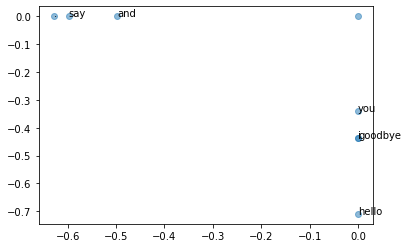

In [17]:
# 각 단어를 2차원으로 표현
for word, word_id in word_to_id.items():
    plt.annotate(word,(U[word_id,0], U[word_id,1]))
    
plt.scatter(U[:,0],U[:,1],alpha=0.5)
plt.show()

In [18]:
# 더 많은 단어가 들어간 데이터를 써보기 위해 ptb (penn treebank) set을 사용해보자.

import sys
sys.path.append('..')
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


In [ ]:
# Dataset 평가

import sys
sys.path.append('..')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from dataset import ptb

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('Co-occurence matrix calculation')
C = create_co_matrix(corpus,vocab_size,window_size)
print('PPMI calculation')
W = ppmi(C, verbose=True)

print('SVD...')
try:
    #truncated SVD
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size,n_iter=5,
                            random_state=None)
    
except ImportError:
    # SVD
    U, S, V = np.lonalg.svd(W)
    
word_vecs = U[:,:wordvec_size]
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)
    
## Comment : 맥북에서 killed. 메모리 문제로 추정. (???????)

Co-occurence matrix calculation
